<a href="https://colab.research.google.com/github/693080593/research/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Algorithm
* object: 
    * Predict ETF closed price in next day using long short term memory(LSTM).
    * Given prices for the last N days, we do prediction for day N+1
    * Find the best N to predict the adjusted close price
    * Get the prediction precision based the rule RMSE and MAPE

In [ ]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
# from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

# Ignore useless warnings
import warnings
warnings.filterwarnings("ignore")

#### Input params ##################
stk_path = "/content/SPY.csv"
test_size = 0.2  # proportion of dataset to be used as test set
cv_size = 0.2  # proportion of dataset to be used as cross-validation set

#### The orignal parameters befor tuning #############
N = 9  # for feature at day t, we use lags from t-1, t-2, ..., t-N as features.
lstm_units = 50  # lstm param. initial value before tuning.
dropout_prob = 1  # lstm param. initial value before tuning.
optimizer = 'adam'  # lstm param. initial value before tuning.
epochs = 1  # lstm param. initial value before tuning.
batch_size = 1  # lstm param. initial value before tuning.

model_seed = 100
fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
#set_random_seed(model_seed)

## Functions for LSTM

In [ ]:
## Compute mean absolute percentage error (MAPE)
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


## Split data into x (features) and y (target)
def get_x_y(data, N, offset):
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i - N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)

    return x, y


def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i - N:i]))
        std_list.append(np.std(data[i - N:i]))
        x_scaled.append(
            (data[i - N:i] - mu_list[i - offset]) / std_list[i - offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)

    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled
        y_train_scaled
        x_cv_scaled        : use this to do predictions 
        y_cv               : actual value of the predictions
        mu_cv_list         : list of the means. Same length as x_scaled and y
        std_cv_list        : list of the std devs. Same length as x_scaled and y 
        lstm_units         : lstm param
        dropout_prob       : lstm param
        optimizer          : lstm param
        epochs             : lstm param
        batch_size         : lstm param
    Outputs
        rmse               : root mean square error
        mape               : mean absolute percentage error
        est                : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(
        LSTM(
            units=lstm_units,
            return_sequences=True,
            input_shape=(x_train_scaled.shape[1], 1)))
    model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(
        x_train_scaled,
        y_train_scaled,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0)

    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(
        -1, 1)) + np.array(mu_cv_list).reshape(-1, 1)

    # Calculate RMSE and MAPE
    #     print("x_cv_scaled = " + str(x_cv_scaled))
    #     print("est_scaled = " + str(est_scaled))
    #     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)

    return rmse, mape, est

## Loading data

In [ ]:
df = pd.read_csv(stk_path, sep=",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2014-03-31,186.669998,187.300003,185.520004,187.009995,169.368149,99745000,3
1,2014-04-01,187.619995,188.360001,187.000000,188.250000,170.491180,89193000,4
2,2014-04-02,188.490005,189.130005,188.139999,188.880005,171.061722,78774000,4
3,2014-04-03,189.169998,189.220001,188.050003,188.630005,170.835327,77435000,4
4,2014-04-04,189.660004,189.699997,186.100006,186.399994,168.815704,169381000,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1259 non-null   datetime64[ns]
 1   open       1259 non-null   float64       
 2   high       1259 non-null   float64       
 3   low        1259 non-null   float64       
 4   close      1259 non-null   float64       
 5   adj_close  1259 non-null   float64       
 6   volume     1259 non-null   int64         
 7   month      1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 88.5 KB


In [ ]:
df.describe()

,open,high,low,close,adj_close,volume,month
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,229.749452,230.744519,228.618133,229.761771,219.240476,9.904178e+07,6.540111
std,31.225691,31.319175,31.100454,31.192640,35.836418,4.879860e+07,3.422864
min,182.139999,183.369995,181.020004,181.509995,164.387024,2.785650e+07,1.000000
25%,204.849998,206.100006,203.959999,204.994996,189.990547,6.653075e+07,4.000000
50%,216.529999,217.119995,215.750000,216.589996,205.805191,8.627080e+07,7.000000
75%,259.970001,261.029999,258.044998,259.794999,255.438476,1.169876e+08,10.000000
max,293.089996,293.940002,291.809998,293.579987,289.286011,5.072443e+08,12.000000


Text(0, 0.5, 'USD')

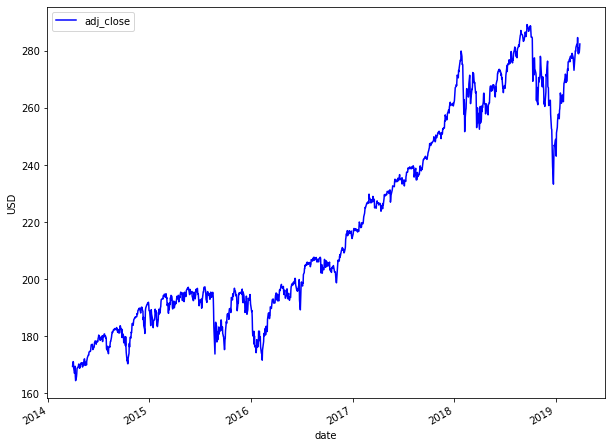

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-')
ax.set_xlabel("date")
ax.set_ylabel("USD")

## Split into training, validation and test sets

We use lags up to N number of days to use as features.

In [ ]:
# Get sizes of each of the datasets
num_cv = int(cv_size * len(df))
num_test = int(test_size * len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'adj_close']]
cv = df[num_train:num_train + num_cv][['date', 'adj_close']]
train_cv = df[:num_train + num_cv][['date', 'adj_close']]
test = df[num_train + num_cv:][['date', 'adj_close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 757
num_cv = 251
num_test = 251
train.shape = (757, 2)
cv.shape = (251, 2)
train_cv.shape = (1008, 2)
test.shape = (251, 2)


In [ ]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(
    np.array(train['adj_close']).reshape(-1, 1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

scaler.mean_ = [192.87917151]
scaler.var_ = [191.67779078]
x_train_scaled.shape = (748, 9, 1)
y_train_scaled.shape = (748, 1)


In [ ]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(
    np.array(train_cv['adj_close']).reshape(-1, 1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (251, 9, 1)
y_cv.shape = (251, 1)
len(mu_cv_list) = 251
len(std_cv_list) = 251


In [ ]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(
    np.array(train_cv['adj_close']).reshape(-1, 1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
# x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N, num_train+num_cv)
# print("x_test_scaled.shape = " + str(x_test_scaled.shape))
# print("y_test.shape = " + str(y_test.shape))
# print("len(mu_test_list) = " + str(len(mu_test_list)))
# print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [206.38325401]
scaler_final.var_ = [746.24550139]


## Create and fit the LSTM network

using the original parameters before tuning.

In [ ]:
# Create the LSTM network
model = Sequential()
model.add(
    LSTM(
        units=lstm_units,
        return_sequences=True,
        input_shape=(x_train_scaled.shape[1], 1)))
model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(
    x_train_scaled,
    y_train_scaled,
    epochs=epochs,
    batch_size=batch_size,
    verbose=2)

Epoch 1/1
 - 5s - loss: 0.0620


In [ ]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


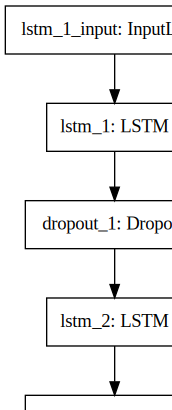

In [ ]:
# Plot model and save to file
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_v4a.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Prediction on validation set

In [ ]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(
    -1, 1)) + np.array(mu_cv_list).reshape(-1, 1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (251, 1)
RMSE = 2.943
MAPE = 0.730%


Text(0, 0.5, 'USD')

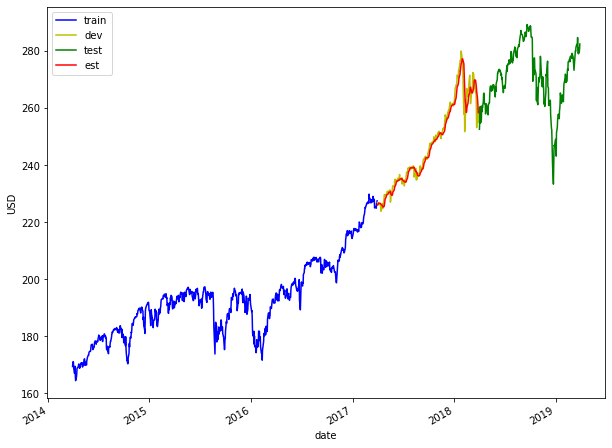

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

est_df = pd.DataFrame({
    'est': est.reshape(-1),
    'y_cv': y_cv.reshape(-1),
    'date': cv['date']
})

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

## Tuning parameters

### Tuning N (number of days to use as features)

**parameters**:

* N = range(3,30)

In [ ]:
param_label = 'N'
param_list = range(3, 30)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):

    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(
        np.array(train_cv['adj_close']).reshape(-1, 1), param, num_train)

    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)

    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))
error_rate


Minutes taken = 4.09599928855896


,N,rmse,mape_pct
0,3,2.461162,0.620054
1,4,2.604064,0.653011
2,5,2.833179,0.710458
3,6,2.785185,0.688355
4,7,2.974729,0.734590
5,8,3.079683,0.759876
6,9,2.937567,0.727503
7,10,2.831814,0.708637
8,11,2.952167,0.721316
9,12,2.954498,0.751539


Text(0, 0.5, 'RMSE/MAPE(%)')

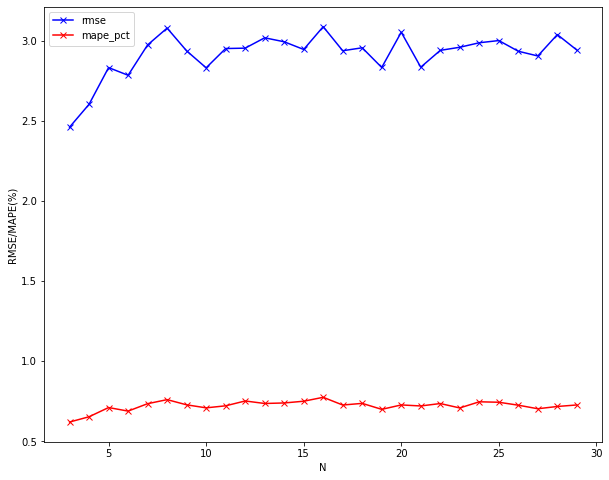

In [ ]:
# Plot RMSE
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-')
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [ ]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 2.461
min MAPE = 0.620%
optimum N = 3


### Tuning model: epochs and batch size

**parameters**:
* epochs = {1, 10, 20, 30, 40, 50}
* batch size = {8, 16, 32, 64, 128}

In [ ]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(
    np.array(train_cv['adj_close']).reshape(-1, 1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):

    for param2 in tqdm_notebook(param2_list):

        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))
error_rate

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
temp = error_rate[error_rate[param2_label] == param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-')
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1, len(param2_list)):
    temp = error_rate[error_rate[param2_label] == param2_list[i]]
    ax = temp.plot(
        x=param_label,
        y='rmse',
        color=color_list[i % len(color_list)],
        marker='s',
        ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(
    legend_list, loc='center left',
    bbox_to_anchor=(1.0, 0.5))  # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

### Tuning model: LSTM units and dropout probability

**parameters**:

* LSTM units = {10, 50, 64, 128}
* dropout probability = {0.5, 0.6, 0.7, 0.8, 0.9, 1}

In [ ]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):

    for param2 in tqdm_notebook(param2_list):

        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))
error_rate

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
temp = error_rate[error_rate[param2_label] == param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-')
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1, len(param2_list)):
    temp = error_rate[error_rate[param2_label] == param2_list[i]]
    ax = temp.plot(
        x=param_label,
        y='rmse',
        color=color_list[i % len(color_list)],
        marker='s',
        ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(
    legend_list, loc='center left',
    bbox_to_anchor=(1.0, 0.5))  # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

### Tuning model: optimizer

**parameters**

* optimizer = {'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam'}

In [ ]:
param_label = 'optimizer'
param_list = [
    'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam'
]

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):

    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)

    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))
error_rate

In [ ]:
# Plot RMSE
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-')
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

### Tuned parameters

Comparison between the original parameters and tuned parameters

In [ ]:
d = {
    'param': [
        'N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size',
        'rmse', 'mape_pct'
    ],
    'original': [
        N, lstm_units, dropout_prob, optimizer, epochs, batch_size,
        rmse_bef_tuning, mape_pct_bef_tuning
    ],
    'after_tuning': [
        N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt,
        batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()
    ]
}
tuned_params = pd.DataFrame(d)
tuned_params

## Final model

In [ ]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt,
                                               N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(
    np.array(df['adj_close']).reshape(-1, 1), N_opt, num_train + num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

est_df = pd.DataFrame({
    'est': est.reshape(-1),
    'date': df[num_train + num_cv:]['date']
})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 2), date(2019, 3, 29)])
ax.set_ylim([220, 300])
ax.set_title("Zoom in to test set")

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 2), date(2019, 3, 29)])
ax.set_ylim([220, 300])

In [ ]:
# Save as csv
test_lstm = est_df
test_lstm.to_csv("/content/test_lstm.csv")

## Result:
* On the test set, the RMSE is 2.632 and MAPE is 0.698% using N_opt=3